## <span style="color:red">Motivation</span>

# The Story of Hollywood - Hollywood as a voice of the times and the cliques that lie within it's top
People have throughout history always look for ways to express themselves through art and since the invention of the Kinetograph, which was the first motion picture camera, by Thomas Edison and his British assistant William Dickson 1890 [1](https://www.pbs.org/wgbh/americanexperience/features/pickford-early-history-motion-pictures/#:~:text=In%201888%20in%20New%20York,a%20primitive%20motion%20picture%20camera.), motion pictures have become increasingly popular. In 2020 the box-office revenue in the US alone was USD $11.300.000$

Skriv noget mere

### Data
Almost everyone have a strong relationship to movies, the intrigue, enlighten, make you cry and make you laugh. We wanted to know more about the structure of the largest productions of them all, and that is why the project evolves around the [tmdb 5000](https://www.kaggle.com/tmdb/tmdb-movie-metadata) dataset. This dataset contains data on the plot, cast, crew, budget, and revenues of several thousand films, but have the advantage that the data is already filtered and cleaned. We choose this dataset as is provides a good foundation of our analysis, but other data sources will also in the report to verify and support the findings.


### Goal of the project
The overall idea of this project is to investigate interesting properties of Hollywood acting environment and how it has developed over time? As the dataset contains a lot of information, these properties have split into two major areas of focus. 
* Movies as a Voice of the times and the Evolution of Hollywood itself
* Hollywood as a closed community structue, with few Actors working alot together. Furthermore, that these communities also exsist outside the set of the movies

There are of course many more interesting elements to look at, kaggle suggests looking at "... the success of a movie before it is released?", or "Are there certain companies (Pixar?) that have found a consistent formula?", but our goal is that after having read this notebook, one would have gotten an in depth understanding of **hollywood as a voice of the times** and **the closed community structure of it**


NOTE: also that the reader experiance some beautifull plots 


## Basic stats of the Data and network

This section will present some basic information about the dataset and initial preperation to allow for the reader to get a good idea abouyt the data the project is working with

In [126]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
import gif


#Init stopwords
stop_words = set(stopwords.words('english'))

# <span style="color:red">Analysis part Two Wikipedia</span>
- [ ] <span style="color:red">Introduction to what we whish to acchieve in this section</span>

- [ ] <span style="color:red">Sentiment</span>

- [ ] <span style="color:red">TF-IDF</span>

Every listed element should be written in the following way:

### WIKIPEDIA YEAR LOOKUP

The second part of the dataset is a lookup of an the year/decades wikipedia page to see if the findings from our analysis corresponds to the sentiment found on the pages. The purpose and hypotesis of this is that we will find a direct correlation between the sentiment of movies and the sorrunding decands data.

One assumption here is that will let the production of hollywood reflect the general state of the world. The reason for this is that there is no pattern wikipedia pattern for year/decade lookup only for the us. Scraping multiple sites will take too much time and loose focus of the important stuff. A reason why this assumption might be allright is due to the fact that the earlies movies in the dataset start around 1970's, which means that society is quite globalised already

**Cleaning and preprocessing**
The data is fetched through the api and is parsed using regex to a raw but filtered state

The filtering applied is:
* Removing links an references to other pages identified by being within <> or {}
* Removing links identified by starting with url=
* Removing non alpha numeric charaters
* Removing links identified by starting with http

This leaves us some partly filtered data still containing stopwords etc. ready for analysis

In [15]:
#The content of the characters' wiki-pages is extracted using the wikipedia API
baseurl = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles='
content = 'prop=revisions&rvprop=content'
dataformat = 'format=json'

def look_up_decade(year: int)-> str:
    decade_start=int(year/10)*10
    query = '%s%s&%s&%s&%s' % (baseurl,action,f'titles={decade_start}s',content,dataformat)
    res = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    pages = res.get('query').get('pages')
    if not pages:
        raise Exception('No pages found')
    data = []
    for page in pages.keys():
        try:
            data.append(res['query']['pages'][page]['revisions'][0]['*'])
        except:
            print(f"Failed on pages{page}")
    return data

def process_data(d:list, limit=3)->list:
    data_string = ''
    temp_str = ''
    
    i=0
    for x in d:
        if i>=limit:
            break
        # Remove special chars and data in links
        temp_str=re.sub("[\{\<.*?[\}\>]", "", x)
        # Remove links
        temp_str=re.sub('url=.\S*','',temp_str)
        # Weird chars
        temp_str=re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str)
        # Remaning links
        temp_str=re.sub('http.\S*','',re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str))
        # Remaning links
        temp_str=re.sub('redirect.\S*','',temp_str)
        data_string += temp_str
        i+=1
    return data_string    

### Create GIF

In [185]:
gif.options.matplotlib["dpi"] = 800

In [186]:
rand_neighbors = []

for i in range(20):
    n1 = np.random.randint(low = 20, high = 40)
    n2 = np.random.randint(low = 5, high = 8)
    n = list(G.neighbors('Samuel L. Jackson'))[n1:n1+n2] + ['Samuel L. Jackson']
    rand_neighbors += [n]

In [187]:
%%capture
frames = []
for n in rand_neighbors:
    frame = plot_graph(G.subgraph(n))
    frames.append(frame)

In [189]:
gif.save(frames, 'network.gif', duration=40, unit="s", between="startend")

### End GIF

In [71]:
# Plot issues
Image(filename='Figure_1.png') 

TypeError: 'module' object is not callable

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones lets take the initial steps to look if we can regonize the mood of the times through the TF-IDF for the decades. Does these correspond with the genre distribution? And do we get the same themes plotting the wordclouds for the moives of the decades against what we find from the historical wikipedia pages?

#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to idetify themes or elements of importance within the identified communities. The expected result is for example some words related to violence and crime to be dominant within the villan community surrounding The Joker


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are

>Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
augmented frequency, to prevent a bias towards longer documents\[2\]

Because the document as fairly similiar for all the movies the bare count was choosen as the TF.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the +1 in the denominator ensuring not division by zero and the other +1 ensuring >1 value for the log fuction.

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - decade in this case 
* The collection $ C $ is the joined documents for all the movies in the  **dataset/corpus** (kan dette siges?)

#### Stopwords
Stopwords contribute very little information and usually gets filtered out through the inverse document frequency, but since the collections is quite small in this case around 8, the IDF penalty for occuring in many documents is simply too small compared to the raw count of the stopwords. To limit problems with this is has been decided to remove the stopwords all together

In [182]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf=Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized



In [289]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

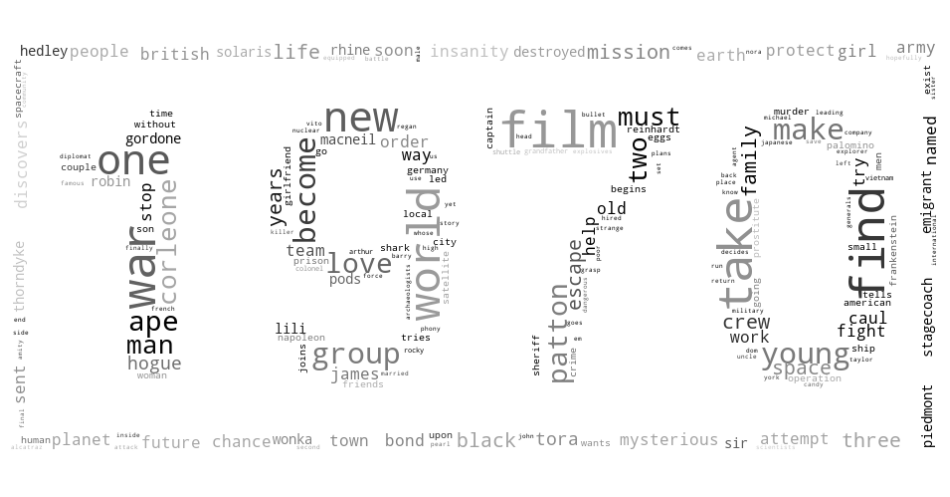

In [290]:
plot_decade_from_tfidf(y, tfidf, top_x_words=200)

### <span style="color:red">Sentiment - copied from comparison section REFACTOR</span>

### Sentiment of the decade
Now we have seen what words are important throught the TF-IDF analysis of the decades. Furthermore, we have gotten and idea of what happens in the world during this time compared to other decades. This was done through the comparison with the globas wiki-pages. **Here we espacially notices INSERT KEY POINTS**. It seems like there could be a correlation between the state of the world an the productions of Hollywood. To dig even further in this we will now take a look at the sentiment of the words. To put it in more general terms: If the world is in bad shape, do hollywood the produce more depressing/sad content?

This section we perform sentiment analysis on the wikipedia data and movie description and relate them to the project hypotesis
**INSERT DEFINITION OF SENTIMENT AND ORIGIN OF DATA ETC. REF TWITTER ARTICLE**


##### <span style="color:red">ADDITIONAL ADDITION</span>


#### Important decision about calculation 
Two important decision:

**Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to the samen word, does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

In relation to the consideration on whether to remove stop words, the course assignment 2[REF](www.githubrepo) revealed that some stop words are non-neutral, and thus the project won't remove stop words from the texts.

A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they don't say anything about the happiness of a text. Thus we remove all words with a happiness average smaller than 6 and larger than 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

Additionally preperation
* all words in the texts are set to lower case

We will start out by creating the foundation for the sentimentanalysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). And filter the data accordin to the described method above

In [359]:
df_s = pd.read_csv('datas1.txt', sep="\t", header=None)
df_s.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
df_s = df_s[1:]
df_s[["happiness_average", "happiness_standard_deviation"]] = df_s[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [354]:
df_s

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
1,laughter,1,8.50,0.9313,3600,--,--,1728
2,happiness,2,8.44,0.9723,1853,2458,--,1230
3,love,3,8.42,1.1082,25,317,328,23
4,happy,4,8.30,0.9949,65,1372,1313,375
5,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10218,murder,10218,1.48,1.0150,2762,3110,1541,1059
10219,terrorism,10219,1.48,0.9089,--,--,3192,--
10220,rape,10220,1.44,0.7866,3133,--,4115,2977
10221,suicide,10221,1.30,0.8391,2124,4707,3319,2107


Now that the data is loaded in, the following formula can be used to calculate the sentiment, for every decade wiki-page and the corresponding movie overview

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

#### <span style="color:red">ADDITIONAL INFORMATION - WHY DESCRIPTION OF ELEMENTS IN FORMULA ETC.</span>


As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [ ]:
def calculate_sentiment_dict(text_dict: dict):
    sentiment_dict = defaultdict(list)
    sentiment_dict_aggregate = {}
    words = list(df_s['word'])
    for year, text in text_dict.items():
        # Check if word in df_s if it is get happiness_average
        _temp = [(word.lower(),df_s[df_s['word']==word.lower()]['happiness_average'].values[0]) for word in text if not df_s[df_s['word']==word.lower()]['happiness_average'].empty]
        # Empty list
        if not _temp:
            continue
        sentiment_dict[year]=_temp
        dc = [x[0] for x in sentiment_dict[year]]
        word_count = nltk.FreqDist(dc).most_common()
        words = 0
        happy_score = 0
        for i in range(len(word_count)):
            words += word_count[i][1]
            happy_score += df_s['happiness_average'][df_s['word'] == word_count[i][0]].values[0]*word_count[i][1]
        v_text = happy_score/words
        sentiment_dict_aggregate[year]=v_text
    return sentiment_dict_aggregate, sentiment_dict

In [498]:
# Calculate sentiment for documents
sentiment_wiki_dict_aggregate, sentiment_wiki_dict = calculate_sentiment_dict(wiki_data)
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

KeyboardInterrupt: 

In [431]:
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry and the wikipedia pages, but how do they relate to eachother and can we relate the sentiment to what we found in the word analysis?

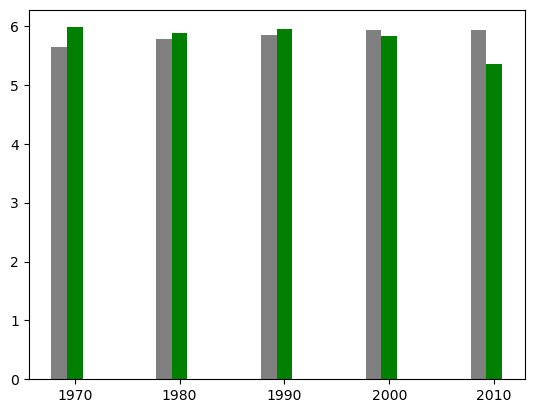

In [442]:
x=np.array(list(sentiment_decade_dict_aggregate.keys()))
y=list(sentiment_decade_dict_aggregate.values())
z=list(sentiment_wiki_dict_aggregate.values())
plt.bar(x-1.5, y, width=1.5, color='grey', align='center', label='wiki')
plt.bar(x, z, width=1.5, color='g', align='center')
plt.show()

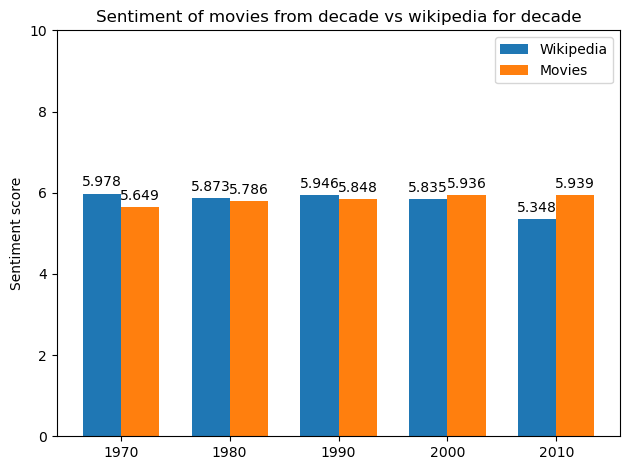

In [449]:
labels = list(sentiment_decade_dict_aggregate.keys())
movies = [round(x,3) for x in list(sentiment_decade_dict_aggregate.values())]
wiki = [round(x,3) for x in list(sentiment_wiki_dict_aggregate.values())]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, wiki, width, label='Wikipedia')
rects2 = ax.bar(x + width/2, movies, width, label='Movies')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment of movies from decade vs wikipedia for decade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,10])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

From the above plot it seems like hollywood reflect the general state of mind of the world, but as the values are centered aroud a neutral is difficult to make any conclusions on the hypotesis. Combining this with the fact that we notice a fairly even distribution between genres we would also expect that the values would be centered around neutral. What should also be noted is that these text segments for the decades are written in a fairly objective manner and therefore might not include many words that are of significant sentiment. On the other hand it might also be that the short movie describtion simply dosen enough positive- or negatively charged words. This is what we will investigate next

I quick look at the sentiment word-list reveals that the most negatively charged words are about terrorism. The movie Zero Dark Thirty about the hunt for Osama Bin Larden, should then be very negativly charged.